In [1]:
import numpy as np
import time
from scipy import misc, ndimage
from PIL import Image
import matplotlib.pyplot as plt
import random
import os
from data_loader import *
from data_visualizer import *

np.random.seed(2018)

import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, Dropout
from keras.optimizers import SGD, Adam
from sklearn.metrics import accuracy_score, f1_score
from keras.models import load_model
from keras.utils import plot_model
from keras_sequential_ascii import keras2ascii
from keras.callbacks import CSVLogger, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, f1_score
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
#inicializace dat
x_train, y_train = load_data()
x_test, y_test = load_test_data()
print(x_train.shape)
print(x_test.shape)

(6625, 64, 64, 3)
(700, 64, 64, 3)


(6592, 64, 64, 3)
(733, 64, 64, 3)


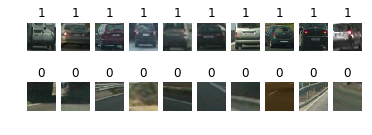

In [6]:
#zobrazení příkladů trénovacího souboru
visualize_examples(x_train, y_train, 10)

In [3]:
# vytvoření validačního souboru, jelikož při zvětšeném objemu dat, je nuté ho vytvořit ručně
def create_val_set(x_train, y_train):
# poměr rozdělení
    split = 0.8
    images_n = x_train.shape[0]
    
# rozdělení indexů poměru a zamýchání indexů
    split_index = int(split * images_n)
    mix_data = np.random.permutation(images_n)
    train_indices = mix_data[0:split_index]
    val_indices = mix_data[split_index:]

# vytvoření nových matic s daty
    new_x_train = x_train[train_indices, :, :]
    new_y_train = y_train[train_indices]
    x_val = x_train[val_indices, :, :]
    y_val = y_train[val_indices]
    
    return new_x_train, new_y_train, x_val, y_val 

In [8]:
# vytvoření modelu neuronové sítě
def train_model(x_train, y_train, epochs, batch_size, optimizer):
    
    # inicializace parametrů
    epochs_n = epochs
    batch_size_n = batch_size
    unit_in_layer = 200
    
    # rozdělení na nový trénovací a validační soubor
    x_train_n, y_train_n, x_val, y_val = create_val_set(x_train, y_train)
    
    # nastavení ImageDataGeneratoru
    datagen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=45,
        vertical_flip=True,
        fill_mode="nearest")
        
    # vytvoření modelu, vstupem není v tomto případě vektor, kvůli automatickému zvětšení dat
    model = Sequential()
    model.add(Dense(units=400, activation = "relu", input_shape = (64,64,3)))
    model.add(Flatten())
    Dropout(0.2)
    model.add(Dense(units=200,activation="relu"))
    Dropout(0.2)
    model.add(Dense(units=100,activation="relu"))
    Dropout(0.2)
    model.add(Dense(units=50,activation="relu"))
    Dropout(0.2)
    model.add(Dense(units=1,activation="sigmoid"))

    # nastavení optimizeru
    if (optimizer == 'sgd'):
        sgd = SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=True)
        model.compile(optimizer = sgd, loss = "binary_crossentropy", metrics = ["accuracy"])
        
    elif (optimizer == 'adam'):
        adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
        model.compile(optimizer = adam, loss = "binary_crossentropy", metrics = ["accuracy"])

        
    print("Máme: " + str(x_train_n.shape[0]) + ' trénovacích obrázků a :' + str(x_val.shape[0]) + ' validačních obrázků')    
    start = time.time()
    # vytvoření logu trénování
    csv_logger = CSVLogger('nn_deep_5_aug_sgd_pyr_50e.log')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
    # trénování modelu model.fit()
    history =  model.fit_generator(datagen.flow(x_train_n, y_train_n, batch_size = batch_size_n),
                                   samples_per_epoch = len(x_train), epochs = epochs_n, 
                                   validation_data = (x_val, y_val), verbose=1, callbacks=[csv_logger, reduce_lr])
    end = time.time()
    
    # vytiskne přehled modelu
    print("Model took %0.2f seconds to train"%(end - start))
    print(model.summary())
    keras2ascii(model)
    print_graphs(history)
    
    # uložení modelu jako .h5
    model.save(r'C:\Users\Petr\Desktop\Bakalářská práce\Neural_networks\deep_nn\nn_deep_5_aug_sgd_pyr_50e.h5')
         
    return history, model

In [ ]:
# trénování modelu
history, model = train_model(x_train, y_train, 50, 32, 'adam')

(6630, 64, 64, 3)
(700, 64, 64, 3)
Máme: 5304 trénovacích obrázků a :1326 validačních obrázků


C:\Users\Petr\Anaconda3\envs\neural\lib\site-packages\ipykernel_launcher.py:51: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., epochs=50, validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=207)`


Epoch 1/50


C:\Users\Petr\Anaconda3\envs\neural\lib\site-packages\keras_preprocessing\image.py:959: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Petr\Anaconda3\envs\neural\lib\site-packages\keras_preprocessing\image.py:967: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


  1/207 [..............................] - ETA: 1:20:18 - loss: 0.6952 - acc: 0.5000

In [10]:
## vytvoření modelu jako obrázku
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
plot_model(model, to_file='model_plot_5_layers_aug.png', show_shapes=True, show_layer_names=True)

In [99]:
#odstranit stávající model
del model

In [92]:
#načtení uloženého modelu
model = load_model('my_model.h5')

In [9]:
# metoda pro udělání predikce na testovacím souboru
def prediction_test(model, x_test, y_test):
    
    test_predictions = model.predict(x_test)
    test_predictions = np.round(test_predictions)

    # vrácení přesnosti predikce
    accuracy = accuracy_score(y_test, test_predictions)
    print("Přesnost testovacího datasetu: " + str(accuracy * 100) + "%")
    
    return test_predictions

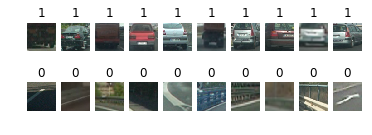

In [13]:
# zobrazení testovacích dat
visualize_examples(x_test, y_test, 10)

In [10]:
# predikce testovacího souboru
test_predictions = prediction_test(model, x_test, y_test)

Přesnost testovacího setu: 97.0%


počet špatných odhadů: 41


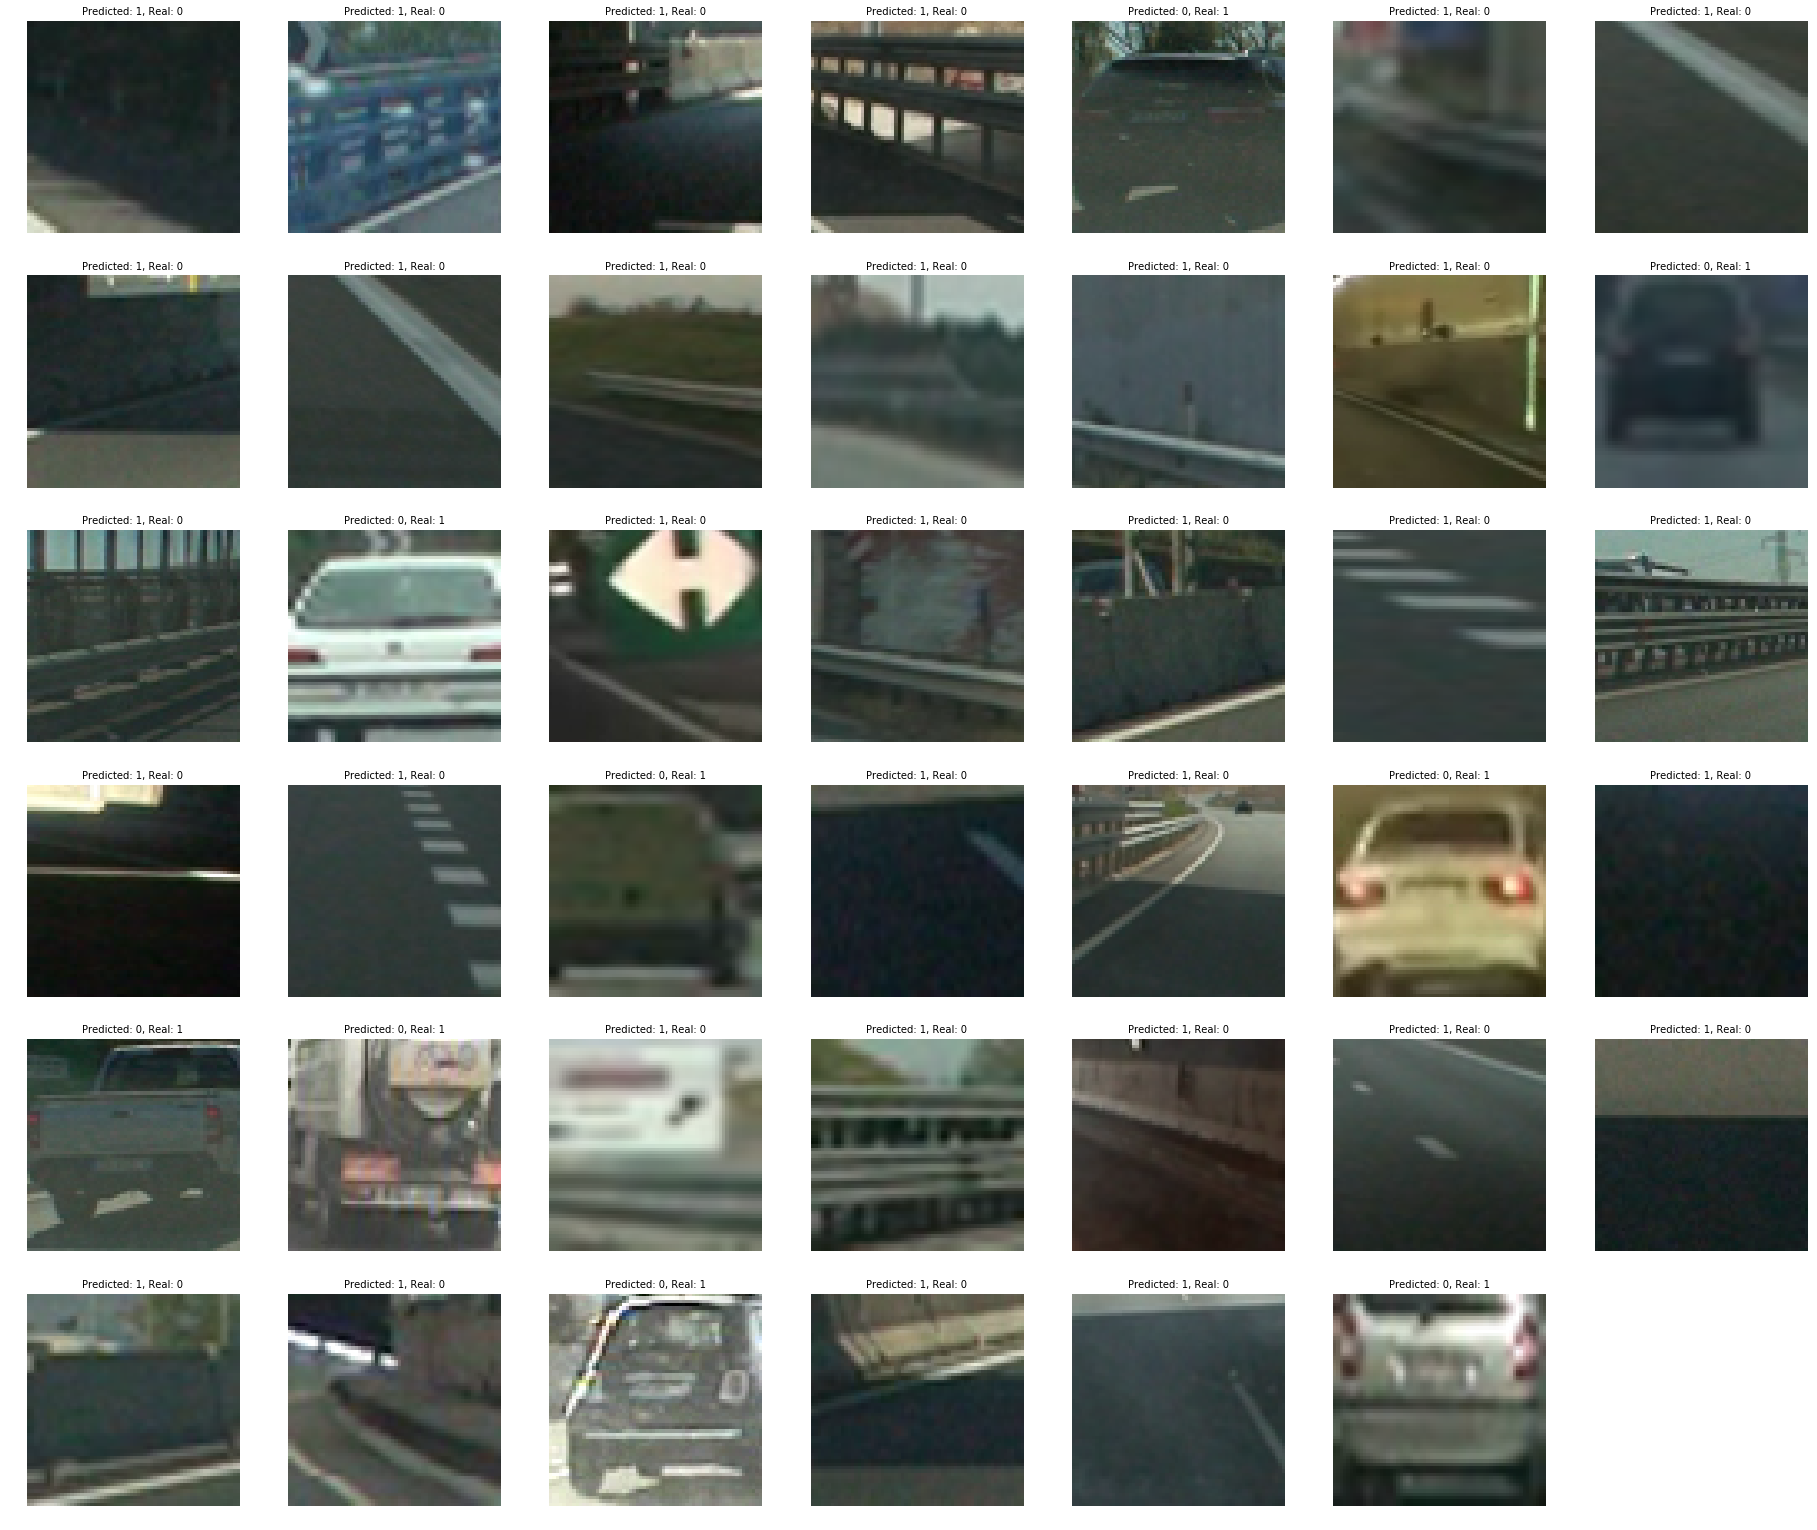

In [16]:
# zobrazení nesprávně označených obrázků
visualize_incorrect_labels(x_test, y_test, np.asarray(test_predictions).ravel())